<a href="https://colab.research.google.com/github/msadeghi322/DeepLearning/blob/main/NMA_SVD_in_Deep_Linear_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Imports
import math
import torch
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

In [17]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from matplotlib import gridspec
from ipywidgets import interact, IntSlider, FloatSlider, fixed
from ipywidgets import FloatLogSlider, Layout, VBox
from ipywidgets import interactive_output
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [18]:
# @title Plotting functions

def plot_x_y_hier_data(im1, im2, subplot_ratio=[1, 2]):
  """
  Plot hierarchical data of labels vs features
  for all samples

  Args:
    im1: np.ndarray
      Input Dataset
    im2: np.ndarray
      Targets
    subplot_ratio: list
      Subplot ratios used to create subplots of varying sizes

  Returns:
    Nothing
  """
  fig = plt.figure(figsize=(12, 5))
  gs = gridspec.GridSpec(1, 2, width_ratios=subplot_ratio)
  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax0.imshow(im1, cmap="cool")
  ax1.imshow(im2, cmap="cool")
  ax0.set_title("Labels of all samples")
  ax1.set_title("Features of all samples")
  ax0.set_axis_off()
  ax1.set_axis_off()
  plt.tight_layout()
  plt.show()


def plot_x_y_hier_one(im1, im2, subplot_ratio=[1, 2]):
  """
  Plot hierarchical data of labels vs features
  for a single sample

  Args:
    im1: np.ndarray
      Input Dataset
    im2: np.ndarray
      Targets
    subplot_ratio: list
      Subplot ratios used to create subplots of varying sizes

  Returns:
    Nothing
  """
  fig = plt.figure(figsize=(12, 1))
  gs = gridspec.GridSpec(1, 2, width_ratios=subplot_ratio)
  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax0.imshow(im1, cmap="cool")
  ax1.imshow(im2, cmap="cool")
  ax0.set_title("Labels of a single sample")
  ax1.set_title("Features of a single sample")
  ax0.set_axis_off()
  ax1.set_axis_off()
  plt.tight_layout()
  plt.show()


def plot_tree_data(label_list = None, feature_array = None, new_feature = None):
  """
  Plot tree data

  Args:
    label_list: np.ndarray
      List of labels [default: None]
    feature_array: np.ndarray
      List of features [default: None]
    new_feature: string
      Enables addition of new features

  Returns:
    Nothing
  """
  cmap = matplotlib.colors.ListedColormap(['cyan', 'magenta'])
  n_features = 10
  n_labels = 8
  im1 = np.eye(n_labels)
  if feature_array is None:
    im2 = np.array([[1, 1, 1, 1, 1, 1, 1, 1],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [1, 1, 1, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 1],
                      [0, 0, 1, 1, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 0, 0],
                      [0, 1, 1, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 0, 1]]).T
    im2[im2 == 0] = -1
    feature_list = ['can_grow',
                    'is_mammal',
                    'has_leaves',
                    'can_move',
                    'has_trunk',
                    'can_fly',
                    'can_swim',
                    'has_stem',
                    'is_warmblooded',
                    'can_flower']
  else:
    im2 = feature_array
  if label_list is None:
    label_list = ['Goldfish', 'Tuna', 'Robin', 'Canary',
                  'Rose', 'Daisy', 'Pine', 'Oak']
  fig = plt.figure(figsize=(12, 7))
  gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.35])
  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])
  ax1.imshow(im1, cmap=cmap)
  if feature_array is None:
    implt = ax2.imshow(im2, cmap=cmap, vmin=-1.0, vmax=1.0)
  else:
    implt = ax2.imshow(im2[:, -n_features:], cmap=cmap, vmin=-1.0, vmax=1.0)
  divider = make_axes_locatable(ax2)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = plt.colorbar(implt, cax=cax, ticks=[-0.5, 0.5])
  cbar.ax.set_yticklabels(['no', 'yes'])
  ax1.set_title("Labels")
  ax1.set_yticks(ticks=np.arange(n_labels))
  ax1.set_yticklabels(labels=label_list)
  ax1.set_xticks(ticks=np.arange(n_labels))
  ax1.set_xticklabels(labels=label_list, rotation='vertical')
  ax2.set_title("{} random Features".format(n_features))
  ax2.set_yticks(ticks=np.arange(n_labels))
  ax2.set_yticklabels(labels=label_list)
  if feature_array is None:
    ax2.set_xticks(ticks=np.arange(n_features))
    ax2.set_xticklabels(labels=feature_list, rotation='vertical')
  else:
    ax2.set_xticks(ticks=[n_features-1])
    ax2.set_xticklabels(labels=[new_feature], rotation='vertical')
  plt.tight_layout()
  plt.show()


def plot_loss(loss_array,
              title="Training loss (Mean Squared Error)",
              c="r"):
  """
  Plot loss function

  Args:
    c: string
      Specifies plot color
    title: string
      Specifies plot title
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  plt.figure(figsize=(10, 5))
  plt.plot(loss_array, color=c)
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.title(title)
  plt.show()


def plot_loss_sv(loss_array, sv_array):
  """
  Plot loss function

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("Set1", n_sing_values)

  _, (plot1, plot2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
  plot1.set_title("Training loss (Mean Squared Error)")
  plot1.plot(loss_array, color='r')

  plot2.set_title("Evolution of singular values (modes)")
  for i in range(n_sing_values):
    plot2.plot(sv_array[:, i], c=cmap(i))
  plot2.set_xlabel("Epoch")
  plt.show()


def plot_loss_sv_twin(loss_array, sv_array):
  """
  Plot learning dynamics

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(10, 5))
  ax1 = plt.gca()
  ax1.set_title("Learning Dynamics")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Mean Squared Error", c='r')
  ax1.tick_params(axis='y', labelcolor='r')
  ax1.plot(loss_array, color='r')

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values (modes)", c='b')
  ax2.tick_params(axis='y', labelcolor='b')
  for i in range(n_sing_values):
    ax2.plot(sv_array[:, i], c=cmap(i))

  fig.tight_layout()
  plt.show()


def plot_ills_sv_twin(ill_array, sv_array, ill_label):
  """
  Plot network training evolution
  and illusory correlations

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    ill_array: np.ndarray
      Log of illusory correlations per epoch
    ill_label: np.ndarray
      Log of labels associated with illusory correlations

  Returns:
    Nothing
  """
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(10, 5))
  ax1 = plt.gca()
  ax1.set_title("Network training and the Illusory Correlations")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel(ill_label, c='r')
  ax1.tick_params(axis='y', labelcolor='r')
  ax1.plot(ill_array, color='r', linewidth=3)
  ax1.set_ylim(-1.05, 1.05)

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values (modes)", c='b')
  ax2.tick_params(axis='y', labelcolor='b')
  for i in range(n_sing_values):
    ax2.plot(sv_array[:, i], c=cmap(i))

  fig.tight_layout()
  plt.show()


def plot_loss_sv_rsm(loss_array, sv_array, rsm_array, i_ep):
  """
  Plot learning dynamics

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    loss_array: np.ndarray
      Log of MSE loss per epoch
    rsm_array: torch.tensor
      Representation similarity matrix
    i_ep: int
      Which epoch to show

  Returns:
    Nothing
  """
  n_ep = loss_array.shape[0]
  rsm_array = rsm_array / np.max(rsm_array)
  sv_array = sv_array / np.max(sv_array)

  n_sing_values = sv_array.shape[1]
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(14, 5))
  gs = gridspec.GridSpec(1, 2, width_ratios=[5, 3])

  ax0 = plt.subplot(gs[1])
  ax0.yaxis.tick_right()
  implot = ax0.imshow(rsm_array[i_ep], cmap="Purples", vmin=0.0, vmax=1.0)
  divider = make_axes_locatable(ax0)
  cax = divider.append_axes("right", size="5%", pad=0.9)
  cbar = plt.colorbar(implot, cax=cax, ticks=[])
  cbar.ax.set_ylabel('Similarity', fontsize=12)
  ax0.set_title("RSM at epoch {}".format(i_ep), fontsize=16)
  ax0.set_yticks(ticks=np.arange(n_sing_values))
  ax0.set_yticklabels(labels=item_names)
  ax0.set_xticks(ticks=np.arange(n_sing_values))
  ax0.set_xticklabels(labels=item_names, rotation='vertical')

  ax1 = plt.subplot(gs[0])
  ax1.set_title("Learning Dynamics", fontsize=16)
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Mean Squared Error", c='r')
  ax1.tick_params(axis='y', labelcolor='r', direction="in")
  ax1.plot(np.arange(n_ep), loss_array, color='r')
  ax1.axvspan(i_ep-2, i_ep+2, alpha=0.2, color='m')

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values", c='b')
  ax2.tick_params(axis='y', labelcolor='b', direction="in")
  for i in range(n_sing_values):
    ax2.plot(np.arange(n_ep), sv_array[:, i], c=cmap(i))
  ax1.set_xlim(-1, n_ep+1)
  ax2.set_xlim(-1, n_ep+1)

  plt.show()

In [19]:
# @title Helper functions

def build_tree(n_levels, n_branches, probability,
               to_np_array=True):
  """
  Builds tree

  Args:
    n_levels: int
      Number of levels in tree
    n_branches: int
      Number of branches in tree
    probability: float
      Flipping probability
    to_np_array: boolean
      If true, represent tree as np.ndarray

  Returns:
    tree: dict if to_np_array=False
          np.ndarray otherwise
      Tree
  """
  assert 0.0 <= probability <= 1.0

  tree = {}

  tree["level"] = [0]
  for i in range(1, n_levels+1):
    tree["level"].extend([i]*(n_branches**i))

  tree["pflip"] = [probability]*len(tree["level"])

  tree["parent"] = [None]
  k = len(tree["level"])-1
  for j in range(k//n_branches):
    tree["parent"].extend([j]*n_branches)

  if to_np_array:
    tree["level"] = np.array(tree["level"])
    tree["pflip"] = np.array(tree["pflip"])
    tree["parent"] = np.array(tree["parent"])

  return tree


def sample_from_tree(tree, n):
  """
  Generates n samples from a tree

  Args:
    tree: np.ndarray/dictionary
      Tree
    n: int
      Number of levels in tree

  Returns:
    x: np.ndarray
      Sample from tree
  """
  items = [i for i, v in enumerate(tree["level"]) if v == max(tree["level"])]
  n_items = len(items)
  x = np.zeros(shape=(n, n_items))
  rand_temp = np.random.rand(n, len(tree["pflip"]))
  flip_temp = np.repeat(tree["pflip"].reshape(1, -1), n, 0)
  samp = (rand_temp > flip_temp) * 2 - 1

  for i in range(n_items):
    j = items[i]
    prop = samp[:, j]
    while tree["parent"][j] is not None:
      j = tree["parent"][j]
      prop = prop * samp[:, j]
    x[:, i] = prop.T
  return x


def generate_hsd():
  """
  Building the tree

  Args:
    None

  Returns:
    tree_labels: np.ndarray
      Tree Labels
    tree_features: np.ndarray
      Sample from tree
  """
  n_branches = 2  # 2 branches at each node
  probability = .15  # flipping probability
  n_levels = 3  # number of levels (depth of tree)
  tree = build_tree(n_levels, n_branches, probability, to_np_array=True)
  tree["pflip"][0] = 0.5
  n_samples = 10000 # Sample this many features

  tree_labels = np.eye(n_branches**n_levels)
  tree_features = sample_from_tree(tree, n_samples).T
  return tree_labels, tree_features


def linear_regression(X, Y):
  """
  Analytical Linear regression

  Args:
    X: np.ndarray
      Input features
    Y: np.ndarray
      Targets

  Returns:
    W: np.ndarray
      Analytical solution
      W = Y @ X.T @ np.linalg.inv(X @ X.T)
  """
  assert isinstance(X, np.ndarray)
  assert isinstance(Y, np.ndarray)
  M, Dx = X.shape
  N, Dy = Y.shape
  assert Dx == Dy
  W = Y @ X.T @ np.linalg.inv(X @ X.T)
  return W


def add_feature(existing_features, new_feature):
  """
  Adding new features to existing tree

  Args:
    existing_features: np.ndarray
      List of features already present in the tree
    new_feature: list
      List of new features to be added

  Returns:
    New features augmented with existing features
  """
  assert isinstance(existing_features, np.ndarray)
  assert isinstance(new_feature, list)
  new_feature = np.array([new_feature]).T
  return np.hstack((tree_features, new_feature))


def net_svd(model, in_dim):
  """
  Performs a Singular Value Decomposition on
  given model weights

  Args:
    model: torch.nn.Module
      Neural network model
    in_dim: int
      The input dimension of the model

  Returns:
    U: torch.tensor
      Orthogonal Matrix
    Σ: torch.tensor
      Diagonal Matrix
    V: torch.tensor
      Orthogonal Matrix
  """
  W_tot = torch.eye(in_dim)
  for weight in model.parameters():
    W_tot = weight.detach() @ W_tot
  U, SIGMA, V = torch.svd(W_tot)
  return U, SIGMA, V


def net_rsm(h):
  """
  Calculates the Representational Similarity Matrix

  Args:
    h: torch.Tensor
      Activity of a hidden layer

  Returns:
    rsm: torch.Tensor
      Representational Similarity Matrix
  """
  rsm = h @ h.T
  return rsm


def initializer_(model, gamma=1e-12):
  """
  In-place Re-initialization of weights

  Args:
    model: torch.nn.Module
      PyTorch neural net model
    gamma: float
      Initialization scale

  Returns:
    Nothing
  """
  for weight in model.parameters():
    n_out, n_in = weight.shape
    sigma = gamma / math.sqrt(n_in + n_out)
    nn.init.normal_(weight, mean=0.0, std=sigma)


def test_initializer_ex(seed):
  """
  Testing initializer implementation

  Args:
    seed: int
      Set for reproducibility

  Returns:
    Nothing
  """
  torch.manual_seed(seed)
  model = LNNet(5000, 5000, 1)
  try:
    ex_initializer_(model, gamma=1)
    std = torch.std(next(iter(model.parameters())).detach()).item()
    if -1e-5 <= (std - 0.01) <= 1e-5:
      print("Well done! Seems to be correct!")
    else:
      print("Please double check your implementation!")
  except:
    print("Faulty Implementation!")


def test_net_svd_ex(seed):
  """
  Tests net_svd_ex exercise

  Args:
    seed: int
      Set for reproducibility

  Returns:
    Nothing
  """
  torch.manual_seed(seed)
  model = LNNet(8, 30, 100)
  try:
    U_ex, Σ_ex, V_ex = ex_net_svd(model, 8)
    U, Σ, V = net_svd(model, 8)
    if (torch.all(torch.isclose(U_ex.detach(), U.detach(), atol=1e-6)) and
        torch.all(torch.isclose(Σ_ex.detach(), Σ.detach(), atol=1e-6)) and
        torch.all(torch.isclose(V_ex.detach(), V.detach(), atol=1e-6))):
      print("Well done! Seems to be correct!")
    else:
      print("Please double check your implementation!")
  except:
    print("Faulty Implementation!")


def test_net_rsm_ex(seed):
  """
  Tests net_rsm_ex implementation

  Args:
    seed: int
      Set for reproducibility

  Returns:
    Nothing
  """
  torch.manual_seed(seed)
  x = torch.rand(7, 17)
  try:
    y_ex = ex_net_rsm(x)
    y = x @ x.T
    if (torch.all(torch.isclose(y_ex, y, atol=1e-6))):
      print("Well done! Seems to be correct!")
    else:
      print("Please double check your implementation!")
  except:
    print("Faulty Implementation!")

In [20]:
#@title Set random seed

#@markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [21]:
#@title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [22]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

print(torch.cuda.is_available())

Random seed 2021 has been set.
GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
True


In [33]:
class LNNet(nn.Module):

  def __init__(self, in_dim, hid_dim, out_dim):


    super().__init__()
    self.in_hid = nn.Linear(in_dim, hid_dim, bias=False)
    self.hid_out = nn.Linear(hid_dim, out_dim, bias = False)

  def forward(self, x):

    hid = self.in_hid(x)
    out = self.hid_out(hid)
    return out , hid



In [24]:
def train(model, inputs, targets, n_epochs, lr, illusory_i=0):
  """
  Training function

  Args:
    model: torch nn.Module
      The neural network
    inputs: torch.Tensor
      Features (input) with shape `[batch_size, input_dim]`
    targets: torch.Tensor
      Targets (labels) with shape `[batch_size, output_dim]`
    n_epochs: int
      Number of training epochs (iterations)
    lr: float
      Learning rate
    illusory_i: int
      Index of illusory feature

  Returns:
    losses: np.ndarray
      Record (evolution) of training loss
    modes: np.ndarray
      Record (evolution) of singular values (dynamic modes)
    rs_mats: np.ndarray
      Record (evolution) of representational similarity matrices
    illusions: np.ndarray
      Record of network prediction for the last feature
  """
  in_dim = inputs.size(1)

  losses = np.zeros(n_epochs)  # Loss records
  modes = np.zeros((n_epochs, in_dim))  # Singular values (modes) records
  rs_mats = []  # Representational similarity matrices
  illusions = np.zeros(n_epochs)  # Prediction for the given feature

  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  for i in range(n_epochs):
    optimizer.zero_grad()
    predictions, hiddens = model(inputs)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()

    # Section 2 Singular value decomposition
    U, Σ, V = net_svd(model, in_dim)

    # Section 3 calculating representational similarity matrix
    RSM = net_rsm(hiddens.detach())

    # Section 4 network prediction of illusory_i inputs for the last feature
    pred_ij = predictions.detach()[illusory_i, -1]

    # Logging (recordings)
    losses[i] = loss.item()
    modes[i] = Σ.detach().numpy()
    rs_mats.append(RSM.numpy())
    illusions[i] = pred_ij.numpy()

  return losses, modes, np.array(rs_mats), illusions

In [25]:
# @title Initialiser of weights based on normal dist
def ex_initializer_(model, gamma=1e-12):
  """
  In-place Re-initialization of weights

  Args:
    model: torch.nn.Module
      PyTorch neural net model
    gamma: float
      Initialization scale

  Returns:
    Nothing
  """
  for weight in model.parameters():
    n_out, n_in = weight.shape
    sigma = gamma/math.sqrt(n_out+n_in)
    nn.init.normal_(weight, mean=0.0, std=sigma)


test_initializer_ex(SEED)

Well done! Seems to be correct!


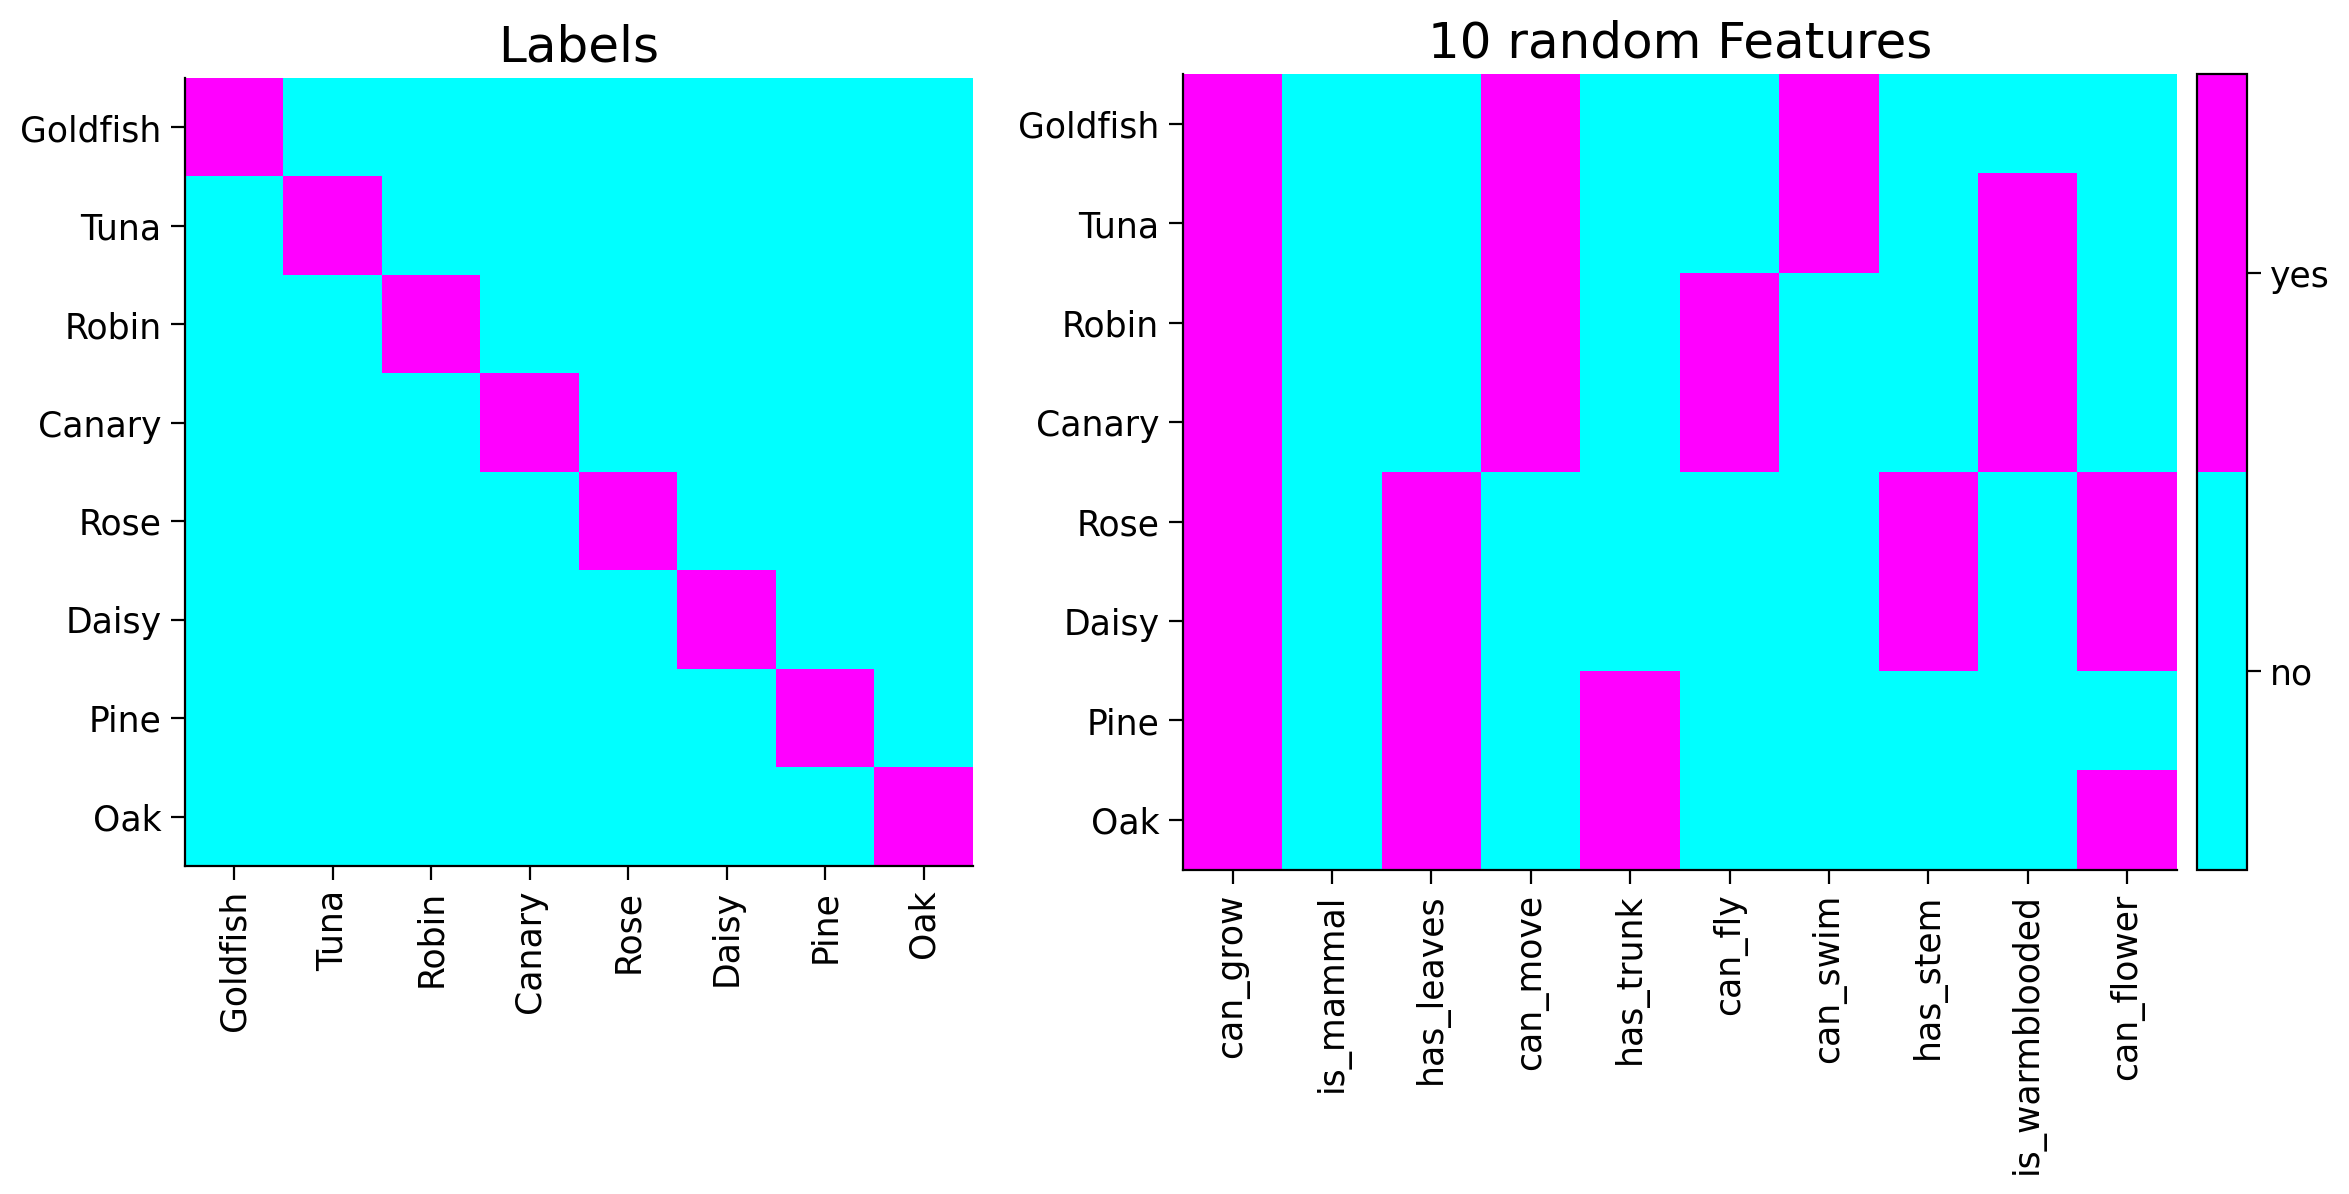

---------------------------------------------------------------
Input Dimension: 8
Output Dimension: 10000
Number of samples: 8


In [26]:

tree_labels, tree_features = generate_hsd()

# Convert (cast) data from np.ndarray to torch.Tensor
label_tensor = torch.tensor(tree_labels).float()
feature_tensor = torch.tensor(tree_features).float()

item_names = ['Goldfish', 'Tuna', 'Robin', 'Canary',
              'Rose', 'Daisy', 'Pine', 'Oak']
plot_tree_data()

# Dimensions
print("---------------------------------------------------------------")
print("Input Dimension: {}".format(tree_labels.shape[1]))
print("Output Dimension: {}".format(tree_features.shape[1]))
print("Number of samples: {}".format(tree_features.shape[0]))

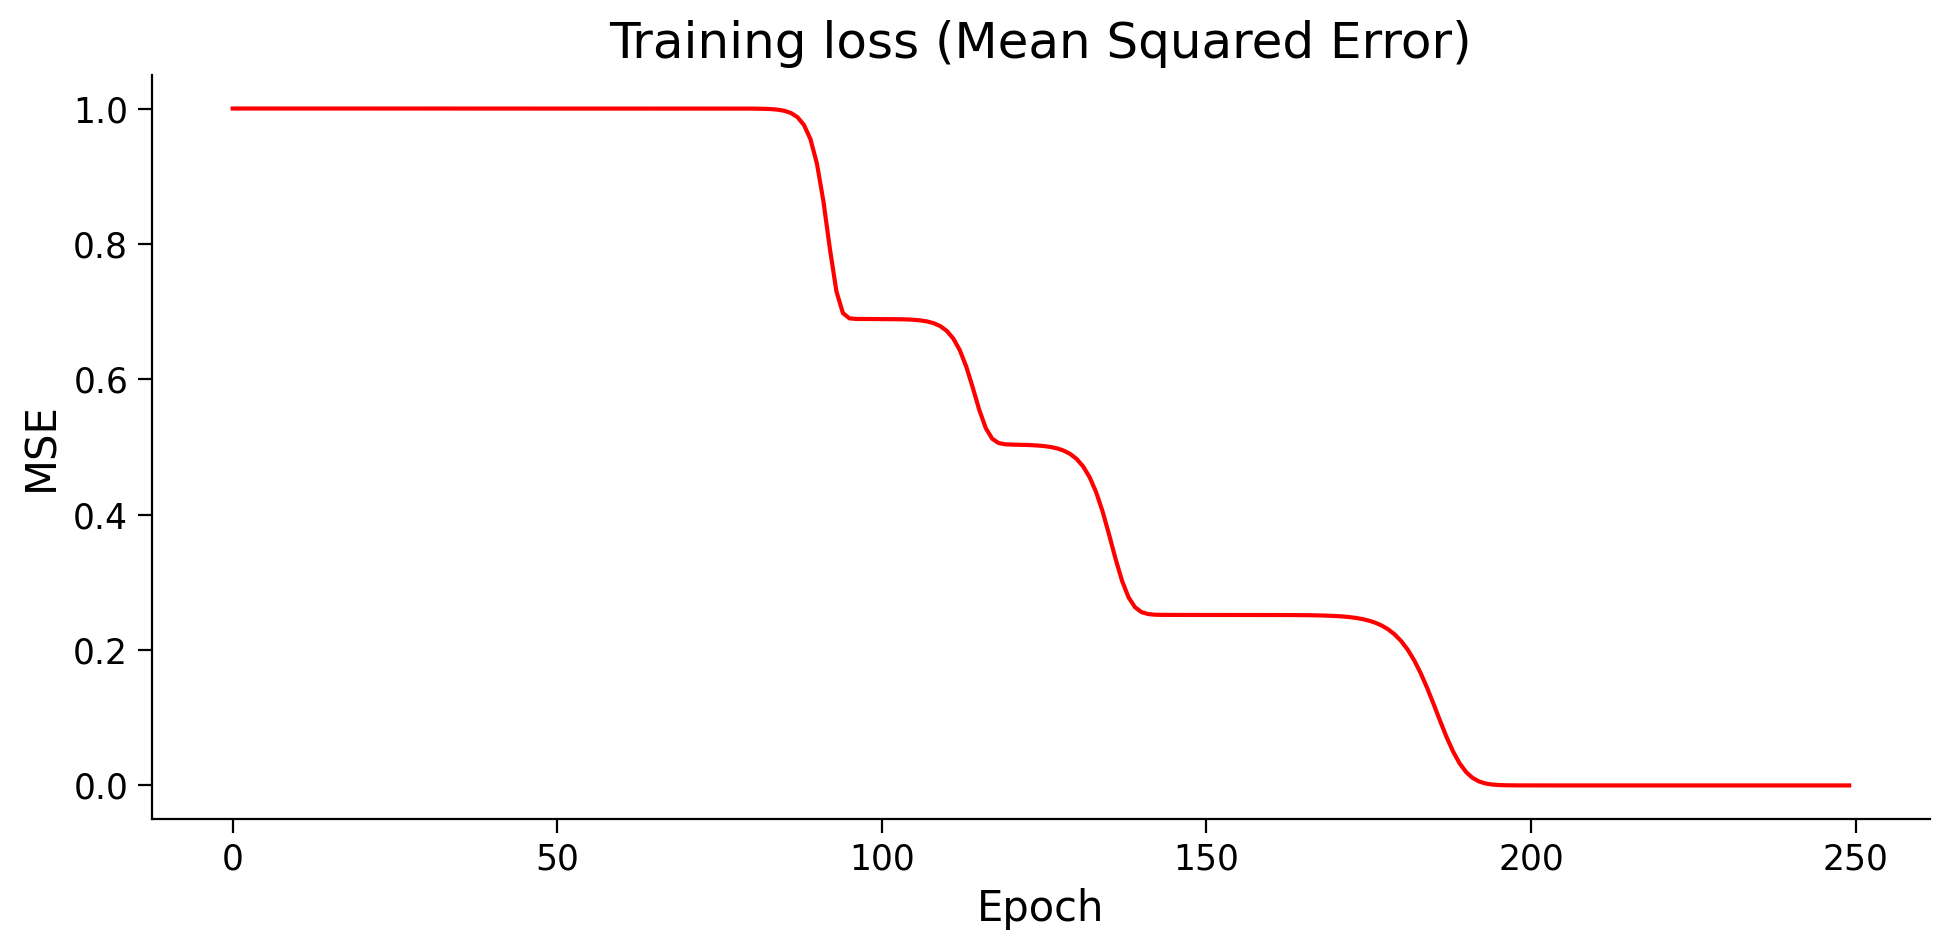

In [31]:

lr = 100.0  # Learning rate
gamma = 1e-12  # Initialization scale
n_epochs = 250  # Number of epochs
dim_input = 8  # Input dimension = `label_tensor.size(1)`
dim_hidden = 30  # Hidden neurons
dim_output = 10000  # Output dimension = `feature_tensor.size(1)`

# Model instantiation
dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

# Weights re-initialization
initializer_(dlnn_model, gamma)

# Training
losses, *_ = train(dlnn_model,
                  label_tensor,
                  feature_tensor,
                  n_epochs=n_epochs,
                  lr=lr)

# Plotting
plot_loss(losses)

In [34]:

def loss_lr_init(lr, gamma):
  """
  Trains and plots the loss evolution

  Args:
    lr: float
      Learning rate
    gamma: float
      Initialization scale

  Returns:
    Nothing
  """
  n_epochs = 250  # Number of epochs
  dim_input = 8  # Input dimension = `label_tensor.size(1)`
  dim_hidden = 30  # Hidden neurons
  dim_output = 10000  # Output dimension = `feature_tensor.size(1)`

  # Model instantiation
  dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

  # Weights re-initialization
  initializer_(dlnn_model, gamma)

  losses, *_ = train(dlnn_model,
                    label_tensor,
                    feature_tensor,
                    n_epochs=n_epochs,
                    lr=lr)

  plot_loss(losses)

_ = interact(loss_lr_init,
             lr = FloatSlider(min=1.0, max=200.0,
                              step=1.0, value=100.0,
                              continuous_update=False,
                              readout_format='.1f',
                              description='eta'),
             epochs = fixed(250),
             gamma = FloatLogSlider(min=-15, max=1,
                                    step=1, value=1e-12, base=10,
                                    continuous_update=False,
                                    description='gamma')
             )

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='eta', max=200.0, min=1.0,…